# Машинное обучение, ФКН ВШЭ

## Практическое задание 4. Классификация. 

### Общая информация
Дата выдачи: 29.10.2021

Мягкий дедлайн: 23:59MSK 10.11.2021 (за каждый день просрочки снимается 1 балл)

Жесткий дедлайн: 23:59MSK 13.11.2021

### О задании

В этом задании вы:
- ознакомитесь с тем, что происходит "внутри" метода опорных векторов и логистической регрессии
- познакомитесь с калибровкой вероятности
- изучите методы трансформации переменных и методы отбора признаков
- попробуете оценить экономический эффект модели


### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.


### Формат сдачи
Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: homework-practice-04-classification-Username.ipynb, где Username — ваша фамилия и имя на латинице именно в таком порядке (например, homework-practice-04-classification-IvanovIvan.ipynb).

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже.

**Оценка**: 

In [205]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import roc_auc_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import make_scorer
import time

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

# Часть 0. SVM, LR и калибровка вероятностей. 

Сгенерируем синтетические данные.

In [271]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5,
    random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

__Задание 1.__ Обучение и применение метода опорных векторов и логистической регрессии.

__(1 балл)__

Обучите метод опорных векторов. На занятиях мы проходили линейный вариант без ядрового перехода, что соответствует линейному ядру (`LinearSVC` или же `SVC(kernel='linear')` в `sklearn.svm`). Подберите параметр регуляризации `C` (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей). __Здесь и далее, если не сказано иначе, подбирайте оптимальные гиперпараметры с точки зрения AUC-PR.__

In [273]:
# сначала отнормируем данные

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# подберем по кросс-валидации параметр регуляризации

C = np.logspace(-6, 2, 9)

searcher = GridSearchCV(LinearSVC(max_iter=200000), [{"C": C}], scoring='average_precision', cv=3)
searcher.fit(X_train, y_train)

best_C = searcher.best_params_["C"]
print("Best SVC C = %.4f" % best_C)

Best SVC C = 0.0010


На тестовой части постройте ROC и PR кривые, а также посчитайте AUC-ROC, AUC-PR с точностью до 5 знаков. Сравните AUC-ROC и AUC-PR для вашей модели с этими же метриками для случайного классификатора (который на каждом объекте выдаёт один из двух классов с равными вероятностями).

In [ ]:
model = LinearSVC(C=best_C, max_iter=200000)
model.fit(X_train, y_train)
y_pred = model.decision_function(X_test)

Я код ниже вот [отсюда](https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python) взяла. Это строю ROC-кривую.

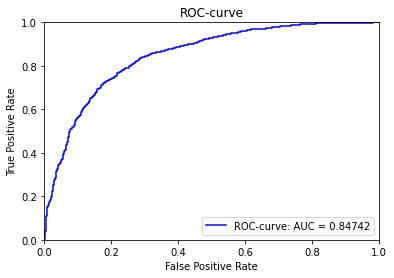

In [ ]:
# fpr -- false positive rate, tpr -- true positive rate
fpr, tpr, threshold = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.title('ROC-curve')
plt.plot(fpr, tpr, 'b', label = 'ROC-curve: AUC = %0.5f' % roc_auc)
plt.legend(loc = 'lower right')
# plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

А следующий код --- [отсюда](https://stackoverflow.com/questions/29656550/how-to-plot-pr-curve-over-10-folds-of-cross-validation-in-scikit-learn). Это PR-кривая.

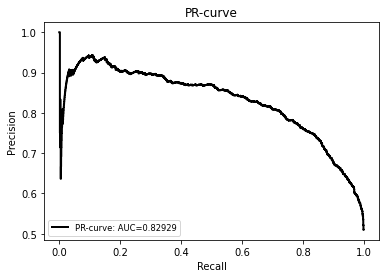

In [ ]:
f, axes = plt.subplots()
precision, recall, _ = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)
lab = 'PR-curve: AUC=%.5f' % (pr_auc)
plt.title('PR-curve')
axes.step(recall, precision, label=lab, lw=2, color='black')
axes.set_xlabel('Recall')
axes.set_ylabel('Precision')
axes.legend(loc='lower left', fontsize='small')

In [ ]:
# выведем AUC-ROC и PR-ROC с точностью до 5 знаков

print('PR-AUC = %.5f' % (pr_auc), '\nROC-AUC = %0.5f' % roc_auc)

PR-AUC = 0.82929 
ROC-AUC = 0.84742


In [ ]:
# посчитаем AUC-ROC и PR-ROC для случайного классификатора

# генерируем ответы для случайного классификатора
y_random = np.random.choice([0, 1], len(y_test))

fpr_random, tpr_random, _ = roc_curve(y_test, y_random)
precision_random, recall_random, _ = precision_recall_curve(y_test, y_random)

random_roc = auc(fpr_random, tpr_random)
random_pr = auc(recall_random, precision_random)

print('PR-AUC for random = %.5f' % random_pr, '\nROC-AUC for random = %0.5f' % random_roc)

PR-AUC for random = 0.64155 
ROC-AUC for random = 0.51391


Видим, что SVM работает все же лучше случайного классификатора))

А теперь проделайте все то же самое для логистической регрессии (LR) — обучение, подбор параметра регуляризации (используйте L2-регуляризацию), вычисление всех метрик и построение кривых. Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).

In [ ]:
# подберем по кросс-валидации параметр регуляризации. l2 по дефолту
C = np.logspace(-6, 2, 9)

searcher = GridSearchCV(LogisticRegression(max_iter=200000), [{"C": C}], scoring='average_precision', cv=3)
searcher.fit(X_train, y_train)

best_C_LR = searcher.best_params_["C"]
print("Best SVC C = %.4f" % best_C_LR)

Best SVC C = 0.0100


In [ ]:
# обучение с лучшим параметром регуляризации
model = LogisticRegression(C=best_C_LR, max_iter=200000)
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)

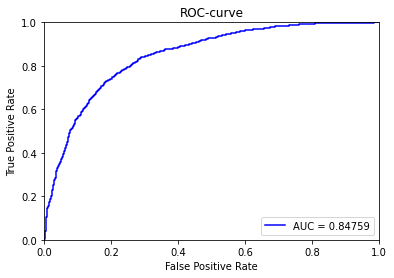

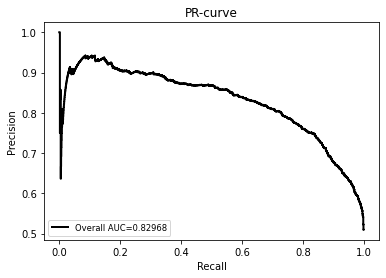

In [ ]:
fpr, tpr, threshold = roc_curve(y_test, y_pred[:, 1])
roc_auc = auc(fpr, tpr)

plt.title('ROC-curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.5f' % roc_auc)
plt.legend(loc = 'lower right')
# plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

f, axes = plt.subplots()
precision, recall, _ = precision_recall_curve(y_test, y_pred[:, 1])
pr_auc = auc(recall, precision)
lab = 'Overall AUC=%.5f' % (pr_auc)
plt.title('PR-curve')
axes.step(recall, precision, label=lab, lw=2, color='black')
axes.set_xlabel('Recall')
axes.set_ylabel('Precision')
axes.legend(loc='lower left', fontsize='small')

In [ ]:
print('PR-AUC = %.5f' % (pr_auc), '\nROC-AUC = %0.5f' % roc_auc)

PR-AUC = 0.83042 
ROC-AUC = 0.77035


Различия есть, но некритичные, на третьем знаке после запятой. На наших данных методы работают почти одинаково хорошо.

В названии метода опорных векторов присутствуют некоторые "опорные векторы". Сгенерируйте синтетические данные с помощью `make_classification` с 2 признаками, обучите на нём метод опорных векторов. Визуализируйте разделяющую прямую, все объекты и выделите опорные векторы (атрибут `support_vectors_`). В этот раз, если необходимо, вместо `LinearSVC` воспользуйтесь `SVC(kernel='linear')`, так как только в нём есть информация об опорных векторах.

In [ ]:
X, y = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0, 
                          n_classes=2, class_sep=2,flip_y=0,
                          random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
C = np.logspace(-6, 2, 9)

searcher = GridSearchCV(SVC(kernel='linear', max_iter=200000), [{"C": C}], scoring='average_precision', cv=3)
searcher.fit(X_train, y_train)

best_C = searcher.best_params_["C"]
print("Best SVC C = %.4f" % best_C)

Best SVC C = 0.1000


In [ ]:
model = SVC(kernel='linear', C=best_C)
model.fit(X_train, y_train)

SVC(C=0.1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

Код посмотрела [тут](https://medium.com/swlh/visualizing-svm-with-python-4b4b238a7a92).

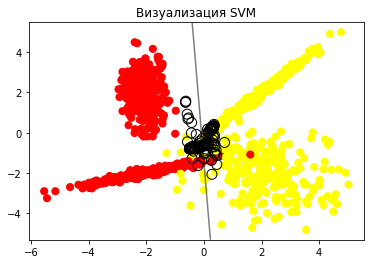

In [ ]:
ax = plt.gca()
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=50, cmap='autumn')
xlim = ax.get_xlim()
ylim = ax.get_ylim()

xx = np.linspace(xlim[0], xlim[1], 70)
yy = np.linspace(ylim[0], ylim[1], 70)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = model.decision_function(xy).reshape(XX.shape)

ax.contour(XX, YY, Z, colors="k", levels=[0], alpha=0.5, linestyles=["-"])

ax.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none', edgecolors='k')

plt.title('Визуализация SVC')
plt.show()

В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость с максимальным отступом, а приближает в каждой точке пространства объектов вероятность положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты. Вам может помочь функция `plt.pcolor`.

In [ ]:
searcher = GridSearchCV(LogisticRegression(max_iter=200000), [{"C": C}], scoring='average_precision', cv=3)
searcher.fit(X_train, y_train)

best_C = searcher.best_params_["C"]
print("Best SVC C = %.4f" % best_C)

Best SVC C = 1.0000


In [ ]:
model = LogisticRegression(C=best_C)
model.fit(X_train, y_train)

Я сначала не поняла совсем, что здесь надо делать, страдала четыре часа, а потом случайно на ответ наткнулась на стэке. Взяла код [оттуда](https://stackoverflow.com/questions/28256058/plotting-decision-boundary-of-logistic-regression), раз такое дело!

[(-5.0, 5.0), Text(0, 0.5, '$X_2$'), (-5.0, 5.0), Text(0.5, 0, '$X_1$'), None]

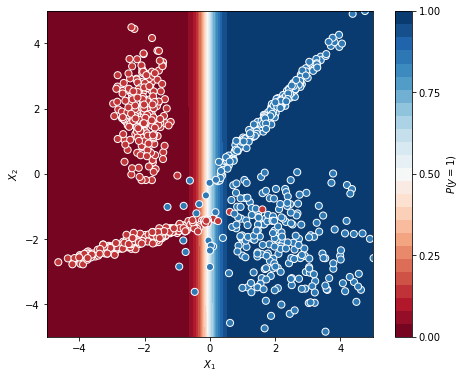

In [ ]:
xx, yy = np.mgrid[-5:5:.01, -5:5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
probs = model.predict_proba(grid)[:, 1].reshape(xx.shape)

f, ax = plt.subplots(figsize=(8, 6))
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X_test[:,0], X_test[:, 1], c=y_test[:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(aspect="equal",
       xlim=(-5, 5), ylim=(-5, 5),
       xlabel="$X_1$", ylabel="$X_2$")

__Задание 2.__ Калибровка вероятностей.

__(1 балл)__

Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых. 

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность? Для этого разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины. Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной. Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [ ]:
def plot_calibration_curve(y_test, preds):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l + r) / 2)
        sec = y_test[(preds >= l) & (preds < r)]
        bin_real_ratios.append(np.sum(sec == 1)/len(sec))
    plt.figure(figsize=(6,6))
    plt.plot(bin_middle_points, bin_real_ratios)
    plt.ylim([-0.05, 1.05])
    plt.grid()

Сгенерируйте синтетические данные аналогично использованным в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$). Изучите распределение ответов классификаторов (постройте гистограммы с помощью `plt.hist`). Чем они различаются? Чем вы можете объяснить это?

In [ ]:
# генерируем данные
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5,
    random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

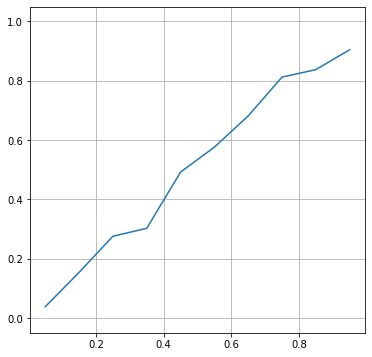

In [ ]:
# для логистической регрессии
model = LogisticRegression(C=1, max_iter=200000)
model.fit(X_train, y_train)
y_pred_log = model.predict_proba(X_test)[:, 1]

plot_calibration_curve(y_test, y_pred_log)

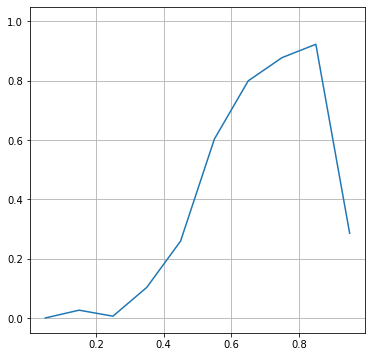

In [ ]:
# для метода опорных векторов
model = SVC(kernel='linear', C=0.1)
model.fit(X_train, y_train)
y_pred = model.decision_function(X_test)
# видимо, тут пока нужно просто перевести в [0, 1] значения без хитростей => отмасштабируем min-max
y_pred = (y_pred - y_pred.min()) / (y_pred.max() - y_pred.min())

plot_calibration_curve(y_test, y_pred)

(array([374., 310., 279., 283., 246., 270., 242., 292., 356., 348.]),
 array([0.00219664, 0.10165933, 0.20112203, 0.30058472, 0.40004741,
        0.4995101 , 0.59897279, 0.69843549, 0.79789818, 0.89736087,
        0.99682356]),
 <a list of 10 Patch objects>)

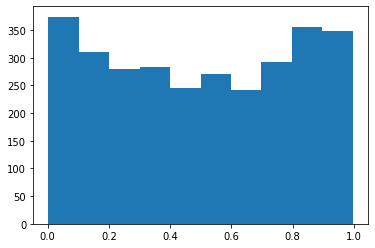

In [ ]:
# теперь построим распределения ответов классификаторов
plt.hist(y_pred_log)

(array([  8.,  38., 165., 387., 624., 715., 628., 336.,  91.,   8.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

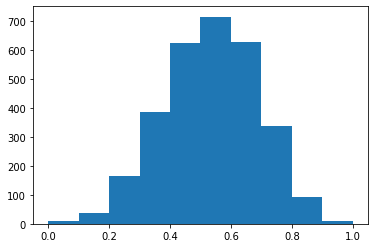

In [ ]:
plt.hist(y_pred)

Заметим, что SVM предсказывает не вероятности: SVM предсказывал уверенности в ответе, а мы эти уверенности отнормировали. Вероятностями они от этого не стали. Но мы исходные уверенности отнормировали --- и, как видим, распределение ответов SVM в итоге очень похоже на нормальное. С ответами логрегрессии мы ничего такого не делали, но логрегрессия, как мы знаем, действительно предсказывает вероятности. Т.к. модели в результате предсказывают совершенно разное (логрегрессия --- вероятности, SVM --- отнормированные уверенности), понятно, что и графики распределений ответов совсем разные.

Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью предсказания для тестовой выборки. Нарисуйте для них калибровочную кривую. Улучшилась ли она?

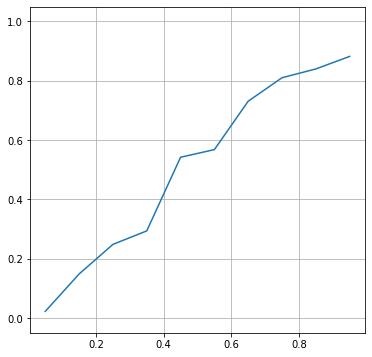

In [ ]:
model = SVC(kernel='linear', C=1)
calibrated_clf = CalibratedClassifierCV(base_estimator=model)
calibrated_clf.fit(X_train, y_train)
y_calibrated = calibrated_clf.predict_proba(X_test)

plot_calibration_curve(y_test, y_calibrated[:, 1])

Да, значительно улучшилась. Как мы поняли из объяснений сверху, вероятности предсказываются тем лучше, чем ближе калибровочная кривая к к графику y = x. Очевидно, что полученная кривая гораздо ближе к графику y = x, чем та, что мы получили простым нормированием ответов.

__Бонусное задание (0.5 балла).__ Реализуйте свою функцию для калибровки вероятностей. Опишите ваш подход и продемонстрируйте результаты. Ключевые слова для вдохновения: `Platt`, `Isotonic`.

Заглянем в семинар по калибровке вероятностей и увидим калибровку Платта и изотоническую регрессию. Калибровка Платта для модели b(x) выглядит чуть приятнее, поэтому, чтобы остались силы на дальнейшие задания, реализуем ее. 

$$p(y = +1 \mid b(x)) = \dfrac{1}{1 + \exp(A \cdot b(x) + C)},$$ 

где A и C --- гиперпараметры. Т.е. нам нужно написать функцию, которая будет брать ответы b(x), подбирать лучшие A и C, и выдавать по формуле выше ответ. Сделаем.

In [ ]:
# создаем чистенькие данные
X, y = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0, 
                          n_classes=2, class_sep=2,flip_y=0,
                          random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(
    X, y, test_size=0.5, random_state=42)

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [ ]:
# обучаем модель, чтобы получить предсказание, которое и будем превращать в вероятности
model = SVC(kernel='linear', C=1)
model.fit(X_train, y_train)

y_pred = model.decision_function(X_val)

Для начала подумаем (пробовала сначала сделать, но результат так себе вышел). 

$$p = \frac{1}{1 + \exp(A \cdot b(x) + C)}$$
$$ $$
$$1 + \exp(A \cdot b(x) + C) = \frac{1}{p}$$
$$ $$
$$A \cdot b(x) + C = \ln \left(\frac{1}{p} - 1 \right)$$
$$ $$
$$\bullet \; p \leq \frac{1}{2} \Rightarrow \ln\left(\frac{1}{p} - 1\right) \geq 0$$
$$ $$
$$\bullet \; p > \frac{1}{2} \Rightarrow \ln\left(\frac{1}{p} - 1\right) < 0$$

Если p > 1/2, то правильный ответ --- скорее 1, а если p <= 1/2 --- то скорее -1 (или 0, если не переобозначили класс 0 за -1). Т.е. p и правильный ответ разных знаков. Поэтому нам, скорее всего, нужно умножить b(x) на какое-то отрицательное число где-то от -50 (потыкала разные нижние границы и увидела, что если делать ее меньше, то лучшее А все еще меньше -27, --- видимо, число очень маленьким становится) и прибавить какое-то небольшое положительное/отрицательное. Может быть, C --- какое-то большое отрицательное, а A --- маленькое положительное, но сначала попробую поискать с отрицательным или небольшим положительным A.

In [ ]:
def platt(A, C, sigm_pred):
  return 1/(1 + np.exp(A * sigm_pred + C))

In [ ]:
A = np.linspace(-50, 0.1, 50)
C = np.linspace(-0.2, 0.2, 20)
best_auc = -1
best_A = 0
best_C = 0

for a in A:
  for c in C:
    res = platt(a, c, y_pred)
    if roc_auc_score(y_val, res) > best_auc:
      best_auc = roc_auc_score(y_val, res)
      best_A = a
      best_C = c

print("Лучшее A:", best_A, "\nЛучшее C:", best_C, "\nЛучший ROC-AUC", best_auc)

Лучшее A: -26.483673469387753 
Лучшее C: 0.1157894736842105 
Лучший ROC-AUC 0.9973759580153282


Такие вот результаты: качество очень высокое получилось!

# Часть 1. Работа с переменными.

В этой части мы научимся обрабатывать категориальные переменные, так как закодировать их в виде чисел недостаточно (это задаёт некоторый порядок, которого на категориальных переменных может и не быть). Существует два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

__Подготовка данных.__

Загрузим данные [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге, объектом в нем является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит), целевой переменной - ответ клиента (согласился ли он открыть депозит?). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
!unzip bank-additional.zip
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

--2021-11-15 14:07:04--  https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 444572 (434K) [application/x-httpd-php]
Saving to: ‘bank-additional.zip.1’

bank-additional.zip 100%[===================>] 434.15K  1.24MB/s    in 0.3s    

2021-11-15 14:07:05 (1.24 MB/s) - ‘bank-additional.zip.1’ saved [444572/444572]

Archive:  bank-additional.zip
replace bank-additional/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: bank-additional/.DS_Store  
replace __MACOSX/bank-additional/._.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: __MACOSX/bank-additional/._.DS_Store  
replace bank-additional/.Rhistory? [y]es, [n]o, [A]ll, [N]one, [r]ename: yy
  inflating: bank-additional/.Rhistory  
replace bank-additional/bank-addition

In [ ]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


__Задание 3 (0.5 балла).__ Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify`. Один из столбцов в данных не несет информации для решения задачи — какой? Отбросьте его. 



In [ ]:
df = df.drop(columns=['duration'])  # в описании признаков написано, что для обучения стоит удалить + это информация о последнем звонке, т.е.
# на который как раз есть ответ. в действительности нам неизвестно, сколько будет длиться звонок, который мы думаем, стоит ли сделать

In [293]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

In [294]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify=y)

Закодируйте категориальные признаки с помощью `OrdinalEncoder`. Посчитайте качество (в этом задании будем работать c `AUC-PR`) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели (с учетом кодирования признаков).

__Вопрос__: почему в данном задании мы выбрали метрикой именно `AUC-PR`, а не, к примеру, `AUC-ROC`?

__Ваш ответ__: как видим ниже, классы в выборке сильно не сбалансированы (ответов 'yes' всего 11%). Знаем, что тогда AUC-ROC не всегда дает адекватные результаты, в то время как AUC-PR устойчив к дисбалансу классов.

In [268]:
cat = ["job", "marital", "education", "default", "housing", "loan", "contact", "month", "day_of_week", "poutcome"]
num = X_train.columns[~X_train.columns.isin(cat)]

# по-моему, education можно будет попробовать рассматривать, как порядковый. но пока двигаемся по заданию

In [295]:
# заменяем yes/no на 1/-1, чтобы можно было считать метрики
y_train = y_train.replace({'no': -1, 'yes': 1})
y_test = y_test.replace({'no': -1, 'yes': 1})

In [ ]:
# посмотрим на баланс классов
sum(y_train == 1)/len(y_train)

0.11265417111780131

In [ ]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import time

column_transformer = ColumnTransformer([
    ('ord', OrdinalEncoder(), cat)
])

pipeline = Pipeline(steps=[
    ('ohe', column_transformer),
    ('regression', LogisticRegression(max_iter=20000))
])

start_time = time.time()
model = pipeline.fit(X_train, y_train)
print("Времени на обучение понадобилось в секундах:", time.time() - start_time)

y_pred = model.decision_function(X_test)

precision, recall, _ = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)

print("AUC-PR:", pr_auc)

Времени на обучение понадобилось в секундах: 0.6945977210998535
AUC-PR: 0.4418413631248986


__Задание 4 (0.5 балла).__ Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.



In [ ]:
# с кодированием
from sklearn.preprocessing import OneHotEncoder

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(), cat)
])

pipeline = Pipeline(steps=[
    ('ohe', column_transformer),
    ('regression', LogisticRegression(max_iter=20000))
])

start_time = time.time()
model = pipeline.fit(X_train, y_train)
y_pred_OHE = model.decision_function(X_test)
print("Времени на обучение понадобилось в секундах:", time.time() - start_time)

precision, recall, _ = precision_recall_curve(y_test, y_pred_OHE)
pr_auc = auc(recall, precision)

print("AUC-PR:", pr_auc)

Времени на обучение понадобилось в секундах: 1.9906682968139648
AUC-PR: 0.4492292264820701


In [ ]:
# без кодирования

pipeline = Pipeline(steps=[
    ('regression', LogisticRegression(max_iter=20000))
])

start_time = time.time()
model = pipeline.fit(X_train, y_train)
print("Времени на обучение понадобилось в секундах:", time.time() - start_time)
y_pred = model.decision_function(X_test)

precision, recall, _ = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)

print("AUC-PR:", pr_auc)

Времени на обучение понадобилось в секундах: 0.1427295207977295
AUC-PR: 0.42340813703483005


Видим, что качество улучшилось на две сотые (по-моему, тоже неплохо! Почти бесплатное для нас улучшение, всяко лучшее никакого).

Как можно было заменить, one-hot-кодирование может сильно увеличивать количество признаков, что сказывается на памяти, особенно, если некоторый признак имеет большое количество значений. Эту проблему решает другой способ кодирования категориальных признаков — mean-target encoding (для простоты будем называть это счётчиками). Основная идея в том, что нам важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:
$$
g_j(x, X) = \frac{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)]}
$$

вопрос в пустоту: что такое j? что такое f?.................

__Задание 5 (1 балл).__ Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве. Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков). Заметили ли вы что-то интересное?


Как кодируем: берем категориальный признак, смотрим, какие у него есть значения. Для каждого значения считаем среднее таргета. Получилось  соответствие (значение категориального признака) <-> число. Это и есть mean-target-кодирование. Так мы сделаем на обучающей выборке.

Тогда, чтобы делать кодирование для тестовой выборки, нам нужно знать для каждого значения категории вычисленное среднее таргета. Т.е. нам стоит хранить словарь с названиями категорий, где каждой категории будет соответствовать еще один список. В этом списке будет название значения категории, а соответствовать ему будет среднее таргета.

In [240]:
import warnings
warnings.filterwarnings("ignore")

starting_code_time = time.time()
# кодируем по обучающей выборке
cat_dict = dict.fromkeys(cat)

# перебираем по категориям
for cat_ in cat:
  # создадим для категории словарь с значениями-ключами
  cat_dict[cat_] = dict.fromkeys(X_train[cat_].unique())
  # кодируем
  for val in X_train[cat_].unique():
    # g_j(x, X) --- это среднее таргета по всем объектам категории
    g = np.mean(y_train[X_train[cat_] == val])
    cat_dict[cat_][val] = g
    X_train.loc[(X_train[cat_] == val), cat_] = g
code_time = time.time() - starting_code_time

In [241]:
# теперь закодируем категориальные признаки в тестовой выборке
test_code_starting_time = time.time()

for cat_ in cat:
  for val in X_test[cat_].unique():
    X_test.loc[(X_test[cat_] == val), cat_] = cat_dict[cat_][val]

test_code_time = time.time() - test_code_starting_time

In [ ]:
fit_start_time = time.time()

model = LogisticRegression(max_iter = 200000)
model.fit(X_train, y_train)

fit_time = time.time() - fit_start_time
final_time = code_time + test_code_time + fit_time

print("Время обучения + кодирования:", final_time)
print("AUC-PR:", average_precision_score(y_test, model.decision_function(X_test)))

Время обучения + кодирования: 1.4904639720916748
AUC-PR: 0.4281656759581016


Училось дольше, чем для OrdinalEncoder, но быстрее, чем для OHE. Качество упало (стало чуть лучше качества случайного классификатора)). Так что интересного ничего не заметила: выше мы получали качество лучше и время работы лучше.

__Бонус (1 балл)__: Здесь и далее реализуйте вычисление счетчиков с помощью трансформера (наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`). Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. Ваш трансформер должен принимать при инициализации список из категориальных признаков и изменять только их. 

In [ ]:
class CatTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, cat):
        self.cat = cat

    def fit(self, X, y):
        self.cat_dict = dict.fromkeys(cat)
        for cat_ in self.cat:
          self.cat_dict[cat_] = dict.fromkeys(X[cat_].unique())
          for val in X[cat_].unique():
            g = np.mean(y[X[cat_] == val])
            self.cat_dict[cat_][val] = g
        return self

    def transform(self, X, y=None):
        X_transformed = X.copy()
        for cat_ in self.cat:
          for val in X_transformed[cat_].unique():
            X_transformed.loc[(X_transformed[cat_] == val), cat_] = self.cat_dict[cat_][val]
        return X_transformed

In [ ]:
# перед запуском сделала повторный запуск ячеек с разделением на трейн и тест и преобразованием таргета
column_transformer = ColumnTransformer([
                                        ('CT', CatTransformer(cat), cat)
                                        ], remainder='passthrough')

pipeline = Pipeline(steps=[
            ('CT', column_transformer),
            ('regression', LogisticRegression(max_iter = 200000))
        ])

start_time = time.time()
model = pipeline.fit(X_train, y_train)
print("AUC-PR:", average_precision_score(y_test, model.decision_function(X_test)))
print("Время обучения + кодирования:", time.time() - start_time)

AUC-PR: 0.42087405094686753
Время обучения + кодирования: 1.0452163219451904


Отметим, что такие признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к переобучению, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его целевая метка не использовалась. Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки. 

__Задание 6.__ Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям (постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков). Снова обучите логистическую регрессию, оцените качество. Сделайте выводы.

__(0.5 балла)__

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class CatTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, cat):
        self.cat = cat

    def fit(self, X, y):
        self.cat_dict = dict.fromkeys(cat)
        for cat_ in self.cat:
          self.cat_dict[cat_] = dict.fromkeys(X[cat_].unique())
          for val in X[cat_].unique():
            g = np.mean(y[X[cat_] == val])
            self.cat_dict[cat_][val] = g
        return self

    def transform(self, X, y=None):
        X_transformed = X.copy()
        for cat_ in self.cat:
          for val in X_transformed[cat_].unique():
            noise = np.random.normal(0, 0.01, len(X_transformed.loc[(X_transformed[cat_] == val), cat_]))
            X_transformed.loc[(X_transformed[cat_] == val), cat_] = self.cat_dict[cat_][val] + noise
        return X_transformed

In [ ]:
column_transformer = ColumnTransformer([
                                        ('CT', CatTransformer(cat), cat)
                                        ], remainder='passthrough')

pipeline = Pipeline(steps=[
            ('CT', column_transformer),
            ('regression', LogisticRegression(max_iter = 200000))
        ])

model = pipeline.fit(X_train, y_train)
print("AUC-PR:", average_precision_score(y_test, model.decision_function(X_test)))

AUC-PR: 0.409455638260196


Вывод: метод конкретно тут бесполезный и даже вредный.

__(Бонусная часть, 0.5 балла)__ Посчитайте корректные счётчики первым или вторым способов из описанных выше (не забудьте добавить и шум). 



In [296]:
# сделаем с помощью кода выше столбцы для каждой категории с результатом кодирования (заменим исходные на них)
# кодируем по обучающей выборке
cat_dict = dict.fromkeys(cat)

# перебираем по категориям
for cat_ in cat:
  for val in X_train[cat_].unique():
    g = np.mean(y_train[X_train[cat_] == val])
    X_train[cat_ + 'Old'] = X_train[cat_]
    X_train.loc[(X_train[cat_] == val), cat_] = g

In [ ]:
# реализуем первый способ. Сначала отсортируем по pdays --- число дней, прошедшее с последнего контакта
X_train = X_train.sort_values(by='pdays')
X_test = X_test.sort_values(by='pdays')

# кодируем тестовую
for cat_ in cat:
  for val in X_train[cat_].unique():
    noise = np.random.normal(0, 0.01, len(X_train.loc[(X_train[cat_] == val), cat_]))
    X_train["cat_higher"] = X_train.groupby(cat_ + 'Old')[cat_].cumsum() + noise

# кодируем тренировочную
for cat_ in cat:
  for val in X_test[cat_].unique():
    noise = np.random.normal(0, 0.01, len(X_test.loc[(X_test[cat_] == val), cat_]))
    X_test["cat_higher"] = X_test.groupby(val)[cat_].cumsum() + noise

In [ ]:
model = LogisticRegression(max_iter = 200000)
model.fit(X_train, y_train)
print("AUC-PR:", average_precision_score(y_test, model.decision_function(X_test)))

А теперь ответьте на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times global\_mean}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$
где $global\_mean$ — доля объектов положительного класса в выборке, $C$ — параметр, определяющий степень сглаживания (например, можно использовать 10 или подобрать для каждого признака свой). Основная идея в том, что мы "разбавляем" среднее значение по некоторой категории глобальным средним значением. И тем меньше, чем большее количество объектов этой категории встречается в выборке. 

Однако для сглаживания вместо среднего значения целевой переменной можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!


__Задание 7 (1 балл).__ Добавьте сглаживание, описанное выше и повторите эксперименты.

In [247]:
beg_time = time.time()

# кодируем на обучающей выборке + кодируем ее
cat_dict = dict.fromkeys(cat)
for cat_ in cat:
  cat_dict[cat_] = dict.fromkeys(X_train[cat_].unique())
  for val in X_train[cat_].unique():
    g = (((y_train[X_train[cat_] == val] == 1).sum() + 10 * y_train.mean())/
        ((y_train[X_train[cat_] == val] == 1).sum() + 10))
    cat_dict[cat_][val] = g
    X_train.loc[(X_train[cat_] == val), cat_] = cat_dict[cat_][val]

code_time = time.time() - beg_time

In [248]:
start_test_time = time.time()

# кодируем тестовую выборку
for cat_ in cat:
  for val in X_test[cat_].unique():
    X_test.loc[(X_test[cat_] == val), cat_] = cat_dict[cat_][val]

# обучаем модель
model = LogisticRegression(max_iter = 200000)
model.fit(X_train, y_train)

test_time = time.time() - start_test_time
print("С global mean\n-----")
print("Время на обучение + кодирование", code_time + test_time)
print("AUC-PR:", average_precision_score(y_test, model.decision_function(X_test)))

С global mean
-----
Время на обучение + кодирование 1.4401872158050537
AUC-PR: 0.5554109588857628


Лучше других методов не стало. Попробуем с другим prior.

In [253]:
beg_time = time.time()

# кодируем на обучающей выборке + кодируем ее
cat_dict = dict.fromkeys(cat)
for cat_ in cat:
  cat_dict[cat_] = dict.fromkeys(X_train[cat_].unique())
  for val in X_train[cat_].unique():
    g = (((y_train[X_train[cat_] == val] == 1).sum() + 10 * 0.01)/
        ((y_train[X_train[cat_] == val] == 1).sum() + 10))
    cat_dict[cat_][val] = g
    X_train.loc[(X_train[cat_] == val), cat_] = cat_dict[cat_][val]

code_time = time.time() - beg_time

In [254]:
start_test_time = time.time()

# кодируем тестовую выборку
for cat_ in cat:
  for val in X_test[cat_].unique():
    X_test.loc[(X_test[cat_] == val), cat_] = cat_dict[cat_][val]

# обучаем модель
model = LogisticRegression(max_iter = 200000)
model.fit(X_train, y_train)

test_time = time.time() - start_test_time
print("С global mean\n-----")
print("Время на обучение + кодирование", code_time + test_time)
print("AUC-PR:", average_precision_score(y_test, model.decision_function(X_test)))

С global mean
-----
Время на обучение + кодирование 1.5717592239379883
AUC-PR: 0.5566493968518744


Тоже лучше не стало. Хорошо, что узнали, что такой метод есть, но нам не пригодился))

__Задание 8 (0.5 балла).__ В данных имеется признак "возраст клиента". Сейчас мы интерпретируем его как числовой, что в общем случае для линейной модели может быть неверной гипотезой. Тем не менее, у этого признака есть довольно много уникальных значений (сколько?), поэтому применять к нему one-hot кодирование может оказаться излишним. Попробуйте закодировать возраст с помощью счетчиков. Стало ли лучше?



In [ ]:
print("Уникальных значений признака Возраст клиента:", len(df["age"].unique()))

Уникальных значений признака Возраст клиента: 78


In [257]:
cat.append('age')
num = X_train.columns[~X_train.columns.isin(cat)]

In [258]:
# делаем сглаживание средним (давало лучшие результаты для счетчиков). кодируем на обучающей выборке + кодируем ее
cat_dict = dict.fromkeys(cat)
for cat_ in cat:
  cat_dict[cat_] = dict.fromkeys(X_train[cat_].unique())
  for val in X_train[cat_].unique():
    g = (((y_train[X_train[cat_] == val] == 1).sum() + 10 * y_train.mean())/
        ((y_train[X_train[cat_] == val] == 1).sum() + 10))
    cat_dict[cat_][val] = g
    X_train.loc[(X_train[cat_] == val), cat_] = cat_dict[cat_][val]

In [259]:
# кодируем тестовую выборку
for cat_ in cat:
  for val in X_test[cat_].unique():
    if val not in cat_dict[cat_].keys():
      cat_dict[cat_][val] = 0
    X_test.loc[(X_test[cat_] == val), cat_] = cat_dict[cat_][val]

In [ ]:
# обучаем модель
model = LogisticRegression(max_iter = 200000)
model.fit(X_train, y_train)

print("AUC-PR:", average_precision_score(y_test, model.decision_function(X_test)))

AUC-PR: 0.4261659497360639


Нет, для OHE по-прежнему лучший результат. Хотя для счетчиков этот результат лучший.

Можно пойти и в обратную сторону. У нас есть признаки "месяц и день недели" для звонка. Попробуйте интерпретировать их как числовые (месяц от 0 до 12, дни недели от 0 до 4). Стало ли лучше в этот раз?

In [ ]:
# снова обновила X_train. можно было не портить на каждом шаге, а делать копию, конечно...
# посмотрим, как записаны месяцы
print(X_train['month'].values, X_train['day_of_week'].values)

['aug' 'jun' 'jun' ... 'jun' 'may' 'aug'] ['wed' 'tue' 'fri' ... 'fri' 'wed' 'fri']


In [263]:
# создадим словарь с соответствиями месяцев и дней их порядковому номеру
months = {'jan': 0, 'feb': 1, 'mar': 2, 'apr':3, 'may': 4, 'jun': 5, 'jul': 6, 'aug': 7, 'sep': 8, 'oct': 9, 'nov': 10, 'dec': 11}
days = {'mon': 0, 'tue': 1, 'wed': 2, 'thu': 3, 'fri': 4}

In [270]:
# трансформируем в X_train
X_train['month'] = X_train['month'].apply(lambda m: months[m])
X_train['day_of_week'] = X_train['day_of_week'].apply(lambda d: days[d])

# трансформируем в X_test
X_test['month'] = X_test['month'].apply(lambda m: months[m])
X_test['day_of_week'] = X_test['day_of_week'].apply(lambda x: days[x])

cat = ["age", "job", "marital", "education", "default", "housing", "loan", "contact", "poutcome"]

# кодируем + кодируем обучающую выборку
cat_dict = dict.fromkeys(cat)
for cat_ in cat:
  cat_dict[cat_] = dict.fromkeys(X_train[cat_].unique())
  for val in X_train[cat_].unique():
    g = (((y_train[X_train[cat_] == val] == 1).sum() + 10 * y_train.mean())/
        ((y_train[X_train[cat_] == val] == 1).sum() + 10))
    cat_dict[cat_][val] = g
    X_train.loc[(X_train[cat_] == val), cat_] = cat_dict[cat_][val]

# кодируем тестовую
for cat_ in cat:
  for val in X_test[cat_].unique():
    if val not in cat_dict[cat_].keys():
      cat_dict[cat_][val] = 0
    X_test.loc[(X_test[cat_] == val), cat_] = cat_dict[cat_][val]
  
# обучаем модель
model = LogisticRegression(max_iter = 200000)
model.fit(X_train, y_train)

print("AUC-PR:", average_precision_score(y_test, model.decision_function(X_test)))

AUC-PR: 0.4230690086542928


Стало чуть хуже (видимо, потому что для нас все же нет порядка, что пятница лучше понедельника и т.д.)

__Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).

Как вы должны были заметить, счётчики являются хорошей альтернативой one-hot-кодированию. Напишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием вы заметили.

__Ответ:__ 

\+ обучение быстрее

\+ признаков меньше

\- качество ниже

# Часть 2. Отбор признаков

Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.

Обратимся к тем же данным про банковский телефонный маркетинг.

In [189]:
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=777, stratify=y)

Как вы помните, в данных много категориальных признаков (сейчас давайте интерпретировать возраст как числовой). Давайте закодируем их с помощью one-hot кодирования. Исходные колонки с категориальными признаками можно удалить. Сколько признаков мы получили?

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

print("Было признаков:", X_train.shape[1])

cat = ["job", "marital", "education", "default", "housing", "loan", "contact", "month", "day_of_week", "poutcome"]
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(), cat)],
    remainder='passthrough'
)

X_train = column_transformer.fit_transform(X_train)
print("Число признаков после OHE:", X_train.shape[1])

Было признаков: 19
Число признаков после OHE 62


В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

In [98]:
X_test = column_transformer.transform(X_test)

In [186]:
model = LogisticRegression(max_iter = 200000)
model.fit(X_train, y_train)
AUC_PR_OHE = average_precision_score(y_test, model.decision_function(X_test))

print("AUC-PR:", AUC_PR_OHE)

AUC-PR: 0.4395049540942016


### Встроенные методы

Допустим, мы хотим оставить только 40 лучших признаков. Попробуем сделать это несколькими способами.

Начнём с отборам признаков с помощью линейной модели. Как известно, веса линейной модели означают вклад каждого признака в предсказание модели, а значит, модуль этого вклада можно интерпретировать как важность признаков. Такой метод отбора называются встроенным или embedded method, так как он заложен в особенности модели.

__Задание 8 (0.5 балла).__ Оставьте 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.

Изменилось ли качество? Как?



In [112]:
beg_time = time.time()
ind = np.argsort(abs(model.coef_))[-40:]  # индексы признаков с наибольшими по модулю весами
print("Время отбора признаков:", time.time() - beg_time)

model.fit(X_train[:, ind[0]], y_train)
print("AUC-PR:", average_precision_score(y_test, model.decision_function(X_test[:, ind[0]])))

Время отбора признаков: 0.0011892318725585938
AUC-PR: 0.44620178131336435


Качество улучшилось на две тысячные! Мелочь, а приятно.

А теперь давайте подумаем, что мы не учли. Мы предположили, что признаки вносят вклад равномерно, но не учли их масштаба. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отмасштабируем признаки одним из способов, а только потом будем удалять признаки. 

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

In [131]:
# сгенерировала заново X_train

num = X_train.columns[~X_train.columns.isin(cat)]

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), cat),
    ('scaling', StandardScaler(), num)
])

pipeline = Pipeline(steps=[
            ('ohe', column_transformer),
            ('regression', LogisticRegression(max_iter=200000))
        ])

model = pipeline.fit(X_train, y_train)

beg_time = time.time()
index = np.argsort(abs(model.steps[1][1].coef_))[0][-40:]
print("Время отбора признаков:", time.time() - beg_time)

# т.к. отобранные признаки --- в закодированном
X_train = column_transformer.fit_transform(X_train)
X_test = column_transformer.transform(X_test)

pipeline = Pipeline(steps=[
            ('regression', LogisticRegression(max_iter=200000))
        ])

model = pipeline.fit(X_train[:, index], y_train)
print("AUC-PR:", average_precision_score(y_test, model.decision_function(X_test[:, index])))

Время отбора признаков: 0.00018978118896484375
AUC-PR: 0.448593281472265


Еще лучше стало! И отбор признаков на заранее отнормированном гораздо быстрее.

Вопрос на засыпку: one-hot кодирование возвращает нам единичные признаки-индикаторы. Попробуйте также отскалировать их, как и обычные числовые, и снова выбрать 40 главных по вкладу признаков. Изменился ли их список? Изменится ли качество?

In [126]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), cat)],
    remainder='passthrough')

pipeline = Pipeline(steps=[
            ('regression', LogisticRegression(max_iter=1000))
        ])

scaler = StandardScaler()

X_train = column_transformer.fit_transform(X_train)  # применили OHE
X_train = scaler.fit_transform(X_train)  # масштабируем все признаки
model = pipeline.fit(X_train, y_train)
index_scaled_all = np.argsort(abs(model.steps[0][1].coef_))[0][-40:]  # отобрали лучшие веса

model = pipeline.fit(X_train[:, index_scaled_all], y_train)  # учимся на лучших весах
X_test = column_transformer.transform(X_test)  # применили OHE к тесту
X_test = scaler.transform(X_test)  # отмасштабировали

print("AUC-PR:", average_precision_score(y_test, model.decision_function(X_test[:, index_scaled_all])))

AUC-PR: 0.4486752805205054


Качество выросло в четвертом знаке после запятой)

In [138]:
set(index_scaled_all) == set(index)

# список признаков изменился

False

### Методы фильтрации


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods. 

В качестве такой функции будем считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.

__Задание 9 (0.5 балла).__ Оставьте 40 признаков с наибольшим значением $t$ и замерьте качество. Не забудьте замерить скорость отбора признаков в этом случае.



In [148]:
# снова загрузила заново X_train

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), cat),
    ('scaling', StandardScaler(), num)
])

X_train = column_transformer.fit_transform(X_train)
X_test = column_transformer.transform(X_test)

t = []
beg_time = time.time()
n_samples, n_features = X_train.shape

for feat in range(n_features):
    n_plus = y_train.sum()
    n_minus = n_samples - n_plus
    mu_plus = (X_train[:, feat][y_train == 1]).mean()
    mu_minus = (X_train[:, feat][y_train == 0]).mean()
    sigma_plus = (X_train[:, feat][y_train == 1]).var()
    sigma_minus = (X_train[:, feat][y_train == 0]).var()
    t.append(abs(mu_plus - mu_minus) / np.sqrt((n_plus * sigma_plus + n_minus * sigma_minus) / n_plus + n_minus))

best_t = np.argsort(t)[-40:]
print("Время отбора признаков:", time.time() - beg_time)

pipeline = Pipeline(steps=[
            ('regression', LogisticRegression(max_iter=200000))
        ])

model = pipeline.fit(X_train[:, best_t], y_train)
print("AUC-PR:", average_precision_score(y_test, model.decision_function(X_test[:, best_t])))

Время отбора признаков: 0.22461152076721191
AUC-PR: 0.4522411598716828


И еще немножко качество выросло!

### Методы-обёртки

__Задание 10 (1 балл).__ 

Третий из рассматриваемых нами методов работает следующим образом: мы исключаем по очереди один из признаков и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества).

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите обучающую выборку на 2 части, на одной из них обучайте модель без одного из признаков,  на второй части оценивайте качество. Исходную тестовую выборку стоит использовать только для финальной оценки качества.

Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Сколько времени занял такой отбор признаков?

In [177]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.5, random_state=777, stratify=y_train)

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), cat),
    ('scaling', StandardScaler(), num)
])

X_train = column_transformer.fit_transform(X_train)
X_val = column_transformer.transform(X_val)

X_test = column_transformer.transform(X_test)
feats = [i for i in range(X_train.shape[1])]
pipeline = Pipeline(steps=[
            ('regression', LogisticRegression(max_iter=200000))
        ])

start_time = time.time()

# остановимся, когда останется только 40 признаков
while len(feats) != 40:
  cv = np.zeros(len(t))
  for i in range(len(t)):
    cur_feats = feats[:i] + feats[(i + 1):]  # выбросили i-й признак
    model = pipeline.fit(X_train[:, cur_feats], y_train)
    y_pred = model.decision_function(X_val[:, cur_feats])
    cv[i] = average_precision_score(y_val, y_pred)
  cv_best_ind = cv.argmax()  # выкинули i-й признак и получили максимальный AUC-PR => надо его выкинуть
  feats.remove(cv_best_ind)

end_time = time.time() - start_time

In [179]:
model = pipeline.fit(X_train[:, feats], y_train)
y_pred = model.decision_function(X_test[:, cv_best])
print("AUC-PR:", average_precision_score(y_test, y_pred))

Время отбора признаков: 859.0256550312042
AUC-PR: 0.45264


Стоит отметить, что с помощью такого метода можно пойти и в обратную сторону. Попробуйте _добавлять_ по одному самому полезному признаку в выборку до тех пор, пока не наберется 40 штук. Найдется ли порог, при котором добавление следующих признаков будет только ухудшать качество модели?

In [190]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.5, random_state=777, stratify=y_train)

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), cat),
    ('scaling', StandardScaler(), num)
])

X_train = column_transformer.fit_transform(X_train)
X_val = column_transformer.transform(X_val)

X_test = column_transformer.transform(X_test)
feats = []
all_feats = [i for i in range(X_train.shape[1])]
pipeline = Pipeline(steps=[
            ('regression', LogisticRegression(max_iter=200000))
        ])
last_PR = 0
start_time = time.time()

# остановимся, когда будет уже 40 признаков
while len(feats) != 40:
  cur_feat = feats[:]
  cv = np.zeros(X_train.shape[1])
  for feat in all_feats:
    cur_feat.append(feat)
    model = pipeline.fit(X_train[:, cur_feats], y_train)
    y_pred = model.decision_function(X_val[:, cur_feats])
    cv[feat] = average_precision_score(y_val, y_pred)
  best_cv_ind = cv.argmax()
  all_feats.remove(best_cv_ind)  # чтобы больше не выбирать среди этих признаков
  feats.append(best_cv_ind)
  if cv[best_cv_ind] < last_PR:
    break
  last_PR = cv[best_cv_ind]
end_time = time.time() - start_time

In [193]:
print("Время отбора признаков:", end_time)
model = pipeline.fit(X_train[:, feats], y_train)
y_pred = model.decision_function(X_test[:, cv_best])
print("AUC-PR:", average_precision_score(y_test, y_pred))

Время отбора признаков: 770.2013561725616
AUC-PR: 0.44958


In [192]:
print(len(feats))  # получается, что может найтись при дальнейшем добавлении признаков

40


Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству?

**Ответ:** Методы-обертки --- очень долгий отбор признаков, хотя улучшение и есть (но не такое, что хочется его так долго ждать). Отбор сорока признаков по отнормированному --- повышает качество, не так долго ждать отбор. Фильтрация с t-статистикой: высокое качество, не слишком долгое ожидание отбора признаков.

В первой вариации метода-обертки получили лучшее качество (незначительно лучшее фильтрации с t-статистикой, работающей значительно быстрее).

# Часть 3. Оценка экономического эффекта модели

В данной части мы займемся тем, что от вас скорее всего потребуется на реальной работе (помимо перекладки `json`, разумеется). А именно: мы соберем несколько специализированных метрик качества, попытаемся настроить модель на максимизацию _прибыли_ и оценим, сколько вообще получится заработать на этом. Разумеется, здесь будет сделано множество упрощающих жизнь допущений, но обо всем по порядку. 

__Задание 11 (1 балл).__ Допустим, работники вашего колл-центра получают за один звонок клиенту 1 доллар. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов.

Если вы всё прослушали на экономике, то напомним, что выручка — это сколько денег нам принесли клиенты, а прибыль — выручка за вычетом расходов на зарплату и прочее.

Загрузите данные о телемаркетинге из предыдущего блока заданий. В этой части не нужно делить выборку - мы будем использовать кросс-валидацию. Используйте 5 фолдов, сделайте `shuffle=True, random_state=500`. По кросс-валидации у вас получится 5 вариантов обучающей и тестовой выборки. Обучите логистическую регрессию на каждой обучающей выборке (воспользуйтесь one-hot для категориальных признаков, гиперпараметры оставьте со значениями по умолчанию) и сделайте предсказания для соответствующих тестовых выборок. Допустим, всем положительным прогнозам ваши сотрудники решили позвонить. Посчитайте на всех тестовых выборках выручку и усредните. Сколько денег вы в среднем заработаете? Также вычислите стандартное отклонение.

Сколько из заработанных денег придётся отдать операторам вашего колл-центра?

In [195]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

# df не успели испортить, так что заново загружать не будем
target = df["y"].apply(lambda y: 0 if y == "no" else 1)
X_feat = df.drop(columns=["y", "duration"])
cat = ["job", "marital", "education", "default", "housing", "loan", "contact", "month", "day_of_week", "poutcome"]
num = X_feat.columns[~X_feat.columns.isin(cat)]

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), cat),
    ('scaler', StandardScaler(), num)
])
pipeline = Pipeline(steps=[
            ('ohe + scaler', column_transformer),
            ('regression', LogisticRegression(max_iter=200000))
])

income = []
profit = []
kf = KFold(n_splits=5, shuffle=True, random_state=500)

for train_index, test_index in kf.split(X_feat):
    X_train, X_test = X_feat.loc[train_index, :], X_feat.loc[test_index, :]
    y_train, y_test = target[train_index], target[test_index]

    model = pipeline.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # получим 10$ от тех, кому мы позвоним и кто правда согласится, 
    # т.е. для кого одновременно и в тесте, и в предсказании true
    inc = 10 * (y_pred & y_test).sum()
    income.append(inc)
    # отдаем с каждого, кому позвонили, по 1$, т.е. всего сколько true в y_pred
    profit.append(inc - y_pred.sum())
    print("Выручка на валидации:", inc)

print("Выручка (среднее по валидации):", np.mean(income))
print("Прибыль (среднее по валидации):", np.mean(profit))
print("В среднем заработаем:", np.mean(income) - np.mean(profit))
print("Стандартное отклонение прибыли:", np.std(profit))

Выручка на валидации 2240
Выручка на валидации 2110
Выручка на валидации 2090
Выручка на валидации 2250
Выручка на валидации 1960
Выручка (среднее по валидации): 2130.0
Прибыль (среднее по валидации): 1805.8
В среднем заработаем: 324.20000000000005
Стандартное отклонение прибыли 108.67640038205167


Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент будет приносить не 10 долларов, а случайную величину, равномерно распределенную в интервале $[0;20)$. Проделайте все те же самые действия. Для имитации реальной ситуации **НЕ** фиксируйте `random_seed` при подсчете выручки с клиента. Что получилось?

In [204]:
income = []
profit = []
kf = KFold(n_splits=5, shuffle=True, random_state=500)

for train_index, test_index in kf.split(X_feat):
    X_train, X_test = X_feat.loc[train_index, :], X_feat.loc[test_index, :]
    y_train, y_test = target[train_index], target[test_index]
    model = pipeline.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    inc = (np.random.uniform(0, 20, len(y_pred)) * (y_pred & y_test)).sum()
    income.append(inc)
    profit.append(inc - y_pred.sum())
    print("Выручка на валидации:", inc)

print("Выручка (среднее по валидации):", np.mean(income))
print("Прибыль (среднее по валидации):", np.mean(profit))
print("В среднем заработаем:", np.mean(income) - np.mean(profit))
print("Стандартное отклонение прибыли", np.std(profit))

Выручка на валидации: 2340.3711220983178
Выручка на валидации: 2012.366389696797
Выручка на валидации: 2091.1148901220076
Выручка на валидации: 2304.9188449078943
Выручка на валидации: 2024.1462414995424
Выручка (среднее по валидации): 2154.5834976649116
Прибыль (среднее по валидации): 1830.3834976649116
В среднем заработаем: 324.20000000000005
Стандартное отклонение прибыли 144.07084377335744


На этом запуске получили выручки и прибыли чуть больше. Стандартное отклонение прибыли увеличилось. А вот средний заработок остался таким же!

Настройте по кросс-валидации коэффициент регуляризации модели для максимизации прибыли (считайте как случайную величину выше). Удалось ли получить какой-то выигрыш? При каком коэффициенте регуляризациии прибыль максимальна? Постройте график зависимости ожидаемой прибыли от коэффициента, также укажите стандартные отклонения (вам поможет `plt.errorbar`).

In [206]:
# создадим функцию, которую будем максимизировать

def profit(y_test, y_pred):
  inc = (np.random.uniform(0, 20, len(y_pred)) * (y_pred & y_test)).sum()
  return inc - y_pred.sum()

In [208]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer

С = np.logspace(-3, 2, 20)
searcher = GridSearchCV(LogisticRegression(max_iter=200000), param_grid={'C': С}, cv=kf, 
                        scoring=make_scorer(profit), n_jobs=-1)

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), cat),
    ('scaling', StandardScaler(), num)
])

pipeline = Pipeline(steps=[
            ('ohe + scaling', column_transformer),
            ('regression', searcher)
        ])

model = pipeline.fit(X_feat, target)
best_С = searcher.best_params_['C']
print("Best С = %.4f" % best_С)
print("Лучшая выручка (среднее по валидации):", searcher.best_score_)

Best С = 0.2336
Лучшая выручка (среднее по валидации) 1848.7971453667335


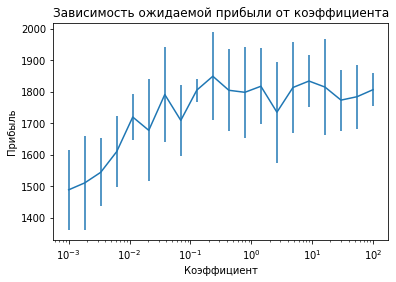

In [218]:
STD = searcher.cv_results_['std_test_score']
profit = searcher.cv_results_['mean_test_score']

plt.errorbar(np.logspace(-3, 2, 20), profit, yerr=STD)
plt.title("Зависимость ожидаемой прибыли от коэффициента")
plt.xscale("log")
plt.xlabel("Коэффициент")
plt.ylabel("Прибыль")
plt.show()

Попробуйте запустить перебор несколько раз. Находится ли каждый раз один и тот же "лучший" коэффициент? Присутствует ли какая-то закономерность? Какие вы можете сделать из этого выводы?

In [220]:
for i in range(5):
    model = pipeline.fit(X_feat, target)
    best_C = searcher.best_params_['C']
    print("Best C = %.4f" % best_C)
    print("Лучшая выручка (среднее по валидации):", searcher.best_score_)

Best C = 8.8587
Лучшая выручка (среднее по валидации): 1884.706816896313
Best C = 1.4384
Лучшая выручка (среднее по валидации): 1854.7209052638427
Best C = 1.4384
Лучшая выручка (среднее по валидации): 1859.0550115019462
Best C = 1.4384
Лучшая выручка (среднее по валидации): 1901.690286053501
Best C = 0.2336
Лучшая выручка (среднее по валидации): 1870.3400399172647


Закономерность неуловима, поэтому С можно не подбирать, а оставлять по умолчанию.

__Задание 12 (1 балл).__ Выше мы уже описали примерную экономическую модель вашей задачи. Как вы считаете, что для вашего бизнеса важнее — хороший precision или recall модели? Почему?

__Ответ:__ Клиенты, которые соглашаются на условия, приносят в десять раз больше прибыли, чем стоит звонок. Поэтому, если мы позвоним одному нужному клиенту и даже девяти ненужным, то мы ничего не потеряем (уйдем в нуль). Поэтому нам выгодно позвонить как можно большему числу клиентов, которые согласятся, хоть и совершить ошибки (в меру разумного), чем позвонить только тем, кто согласится, но в маленьком количестве. Звонки тем, кто откажется от наших условий, нам не так дорого обходятся. Поэтому важнее хороший recall.

Вспомним, что на самом деле логистическая регрессия предсказывает нам вероятности положительного класса для объекта. Возможно, путем настройки порога бинаризации этих вероятностей мы сможем получить какой-то выигрыш? Проверьте ваши рассуждения выше с помощью настройки порога бинаризации на кросс-валидации для максимизации прибыли. Воспользуйтесь сеткой от 0 до 1 с шагом 0.01. Напомним, что снижение порога дает нам более высокий recall и более низкий precision, и наоборот.

In [221]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), cat),
    ('scaler', StandardScaler(), num)
])
pipeline = Pipeline(steps=[
            ('ohe + scaler', column_transformer),
            ('regression', LogisticRegression(max_iter=1000))
])

# для валидации
income = [[]] * 5
profit = [[]] * 5
thresholds = [i / 100 for i in range(100)]

# для порогов
for i in range(5):
    income[i] = [0] * 100
    profit[i] = [0] * 100

kf = KFold(n_splits=5, shuffle=True, random_state=500)
k = 0  # счетчик для разбиений

for train_index, test_index in kf.split(X_feat):
    # разбиваем на трейн и тест в валидаци
    X_train, X_test = X_feat.loc[train_index, :], X_feat.loc[test_index, :]
    y_train, y_test = target[train_index], target[test_index]
    model = pipeline.fit(X_train, y_train)

    t = 0  # для номера порога
    # перебираем пороги
    for threshold in thresholds:
        y_pred = np.where(model.predict_proba(X_test)[:, 1] > threshold, 1, 0)
        income[k][t] = (np.random.uniform(0, 20, len(y_pred)) * (y_pred & y_test)).sum()
        profit[k][t] = (income[k][t] - y_pred.sum())
        t += 1
    k += 1

Постройте график зависимости прибыли от порога бинаризации, также отметьте на нем стандартные отклонения. Выделите наилучший порог. 


__Вопрос:__ Замечаете ли вы какую-то закономерность? Для правильного ответа на этот вопрос попробуйте запустить несколько раз и задумайтесь, почему порог получается в какой-то конкретной области?

__Ответ__: До порога 0.2 прибыль растет, а после --- уменьшается. Это соответствует нашему утверждению, что нам важнее высокий recall (как сказано в напоминании, для этого нам нужны меньшие пороги).

In [231]:
best_threshold = thresholds[profit.index(max(profit))]
print("Лучший порог:", best_threshold)

Лучший порог: 0.04


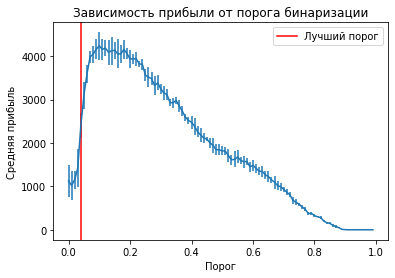

In [235]:
mean_profit = np.mean(profit, axis=0)
std = np.std(profit, axis=0)

plt.errorbar(thresholds, mean_profit, yerr=std)
plt.axvline(x=best_threshold, color='r')
plt.legend(['Лучший порог'])
plt.title("Зависимость прибыли от порога бинаризации")
plt.xlabel("Порог")
plt.ylabel("Средняя прибыль")
plt.show()

Каковы значения precision и recall на выбранном пороге? Оцените по кросс-валидации. Также вычислите стандартное отклонение.

In [236]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

precision = []
recall = []

for train_index, test_index in kf.split(X_feat):
    X_train, X_test = X_feat.loc[train_index, :], X_feat.loc[test_index, :]
    y_train, y_test = target[train_index], target[test_index]

    model = pipeline.fit(X_train, y_train)
    y_pred = np.where(model.predict_proba(X_test)[:, 1] > best_threshold, 1, 0)
    precision.append(precision_score(y_test, y_pred))
    recall.append(recall_score(y_test, y_pred))

print("Precision:", np.mean(precision))
print("Стандартное отклонение precision:", np.std(precision))
print("Recall:", np.mean(recall))
print("Стандартное отклонение recall:", np.std(recall))

Precision: 0.13904306186073337
Стандартное отклонение precision: 0.004925954777496425
Recall: 0.9203482219201238
Стандартное отклонение recall: 0.012265441221981555


Как вы, вероятно, уже поняли, ваша модель склоняется к более высокому recall. Попробуйте оценить качество модели с помощью `PR-AUC` в зоне recall $\geq$ 0.5. Сделайте это следующим образом - выберите только те пороги, на которых достигается необходимый recall, затем интерпретируйте отсеченный в единичном квадрате прямоугольник как новый единичный квадрат и посчитайте площадь под отсеченной кривой. 

In [238]:
import warnings
warnings.filterwarnings("ignore")

precision = [[]] * 5
recall = [[]] * 5
thresholds = [i / 100 for i in range(100)]

for cv in range(5):
    precision[cv] = [0] * 100
    recall[cv] = [0] * 100

kf = KFold(n_splits=5, shuffle=True, random_state=500)
k = 0

for train_index, test_index in kf.split(X_feat):
    # трейн и тест на кросс-валидации
    X_train, X_test = X_feat.loc[train_index, :], X_feat.loc[test_index, :]
    y_train, y_test = target[train_index], target[test_index]
    model = pipeline.fit(X_train, y_train)

    # перебираем пороги
    t = 0
    for threshold in thresholds:
        y_pred = np.where(model.predict_proba(X_test)[:, 1] > threshold, 1, 0)
        precision[k][t] = precision_score(y_test, y_pred)
        recall[k][t] = recall_score(y_test, y_pred)
        t += 1
    k += 1

precision_mean = np.mean(precision, axis=0)
recall_mean = np.mean(recall, axis=0)

# теперь в зоне precision >= 0.5
precision_5 = []
recall_5 = []

for i in range(100):
    if recall_mean[i] >= 0.5:
      precision_5.append(precision_mean[i])
      recall_5.append(recall_mean[i])

diff_precision = np.max(precision_5) - np.min(precision_5)
diff_recall = np.max(recall_5) - np.min(recall_5)

precision_ = (precision_5 - np.min(precision_5)) / diff_precision
recall_ = (recall_5 - np.min(recall_5)) / diff_recall
print("PR-AUC:", auc(recall_, precision_))

PR-AUC: 0.39986240078872226
